# Logistic regression

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv

sns.set_style("whitegrid")

In [2]:
import pandas as pd

# Load the CSV using the absolute path
data = pd.read_csv('../data/data_processed.csv')

# Check the first few rows to confirm
print(data.head())


              race  age  time_in_hospital  num_lab_procedures  num_procedures  \
0        Caucasian    0                 1                  41               0   
1        Caucasian    1                 3                  59               0   
2  AfricanAmerican    2                 2                  11               5   
3        Caucasian    3                 2                  44               1   
4        Caucasian    4                 1                  51               0   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0                1                  0                 0                 0   
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   

   number_diagnoses  ...  pt_admission_source_2_ct

In [3]:
print(data.info())
print(data.describe())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97108 entries, 0 to 97107
Data columns (total 90 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   race                       97108 non-null  object
 1   age                        97108 non-null  int64 
 2   time_in_hospital           97108 non-null  int64 
 3   num_lab_procedures         97108 non-null  int64 
 4   num_procedures             97108 non-null  int64 
 5   num_medications            97108 non-null  int64 
 6   number_outpatient          97108 non-null  int64 
 7   number_emergency           97108 non-null  int64 
 8   number_inpatient           97108 non-null  int64 
 9   number_diagnoses           97108 non-null  int64 
 10  max_glu_serum              97108 non-null  int64 
 11  A1Cresult                  97108 non-null  int64 
 12  metformin                  97108 non-null  int64 
 13  glimepiride                97108 non-null  int64 
 14  glipiz

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_curve, auc, accuracy_score

#  data is already loaded into 'data'
# and that the target column is named 'readmitted' or similar
# Replace 'readmitted' below with your actual target column name

# Check unique values in your target column
print(data['readmitted'].value_counts())

readmitted
NO     51018
>30    34964
<30    11126
Name: count, dtype: int64


In [5]:
# If target is categorical like '<30', '>30', 'NO', convert to binary
data['readmitted_binary'] = data['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

# Prepare features and target
X = data.drop(['readmitted', 'readmitted_binary'], axis=1)
y = data['readmitted_binary']


In [6]:
X['strat_col'] = X['race'].astype(str) + "_" + data['readmitted_binary'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = X['strat_col'], random_state = 42)
X_train = X_train.drop(columns = ['strat_col' , 'race'])
X_test = X_test.drop(columns = ['strat_col' , 'race'])

In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [9]:
probs = model.predict_proba(X_test_scaled)
y_pred = (probs[:, 1]>=0.5)

Confusion Matrix:
[[8826 1377]
 [3406 5813]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79     10203
           1       0.81      0.63      0.71      9219

    accuracy                           0.75     19422
   macro avg       0.77      0.75      0.75     19422
weighted avg       0.76      0.75      0.75     19422

Mean squared error =  0.24626711976109567
Accuracy =  0.7537328802389044
ROC AUC score =  0.8086128731771611


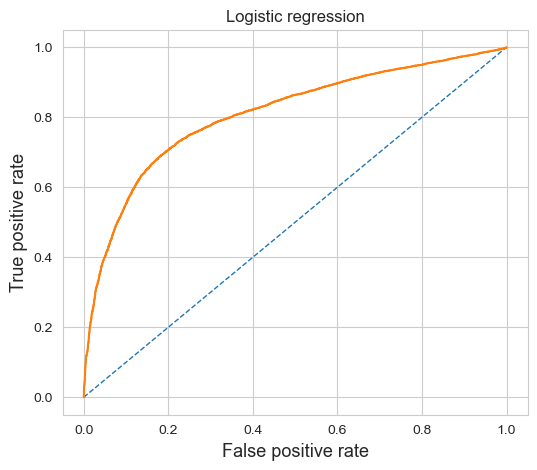

In [10]:
# --- Evaluate Model ---
#y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, probs[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)

roc_data = pd.DataFrame({'X': false_pos_rate.tolist(), 'Y': true_pos_rate.tolist()})
roc_data.to_csv('./figs/plot_data/bal_roc_curve_logreg.csv', index=False)
    

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Mean squared error = ",mse)
print("Accuracy = ",acc)
print("ROC AUC score = ",roc_auc)

plt.figure(figsize = (6,5))
plt.plot([0,1], [0,1], '--', lw=1)
plt.plot(false_pos_rate, true_pos_rate)
plt.xlabel('False positive rate', fontsize=13)
plt.ylabel('True positive rate', fontsize=13)
plt.title('Logistic regression')
plt.show()

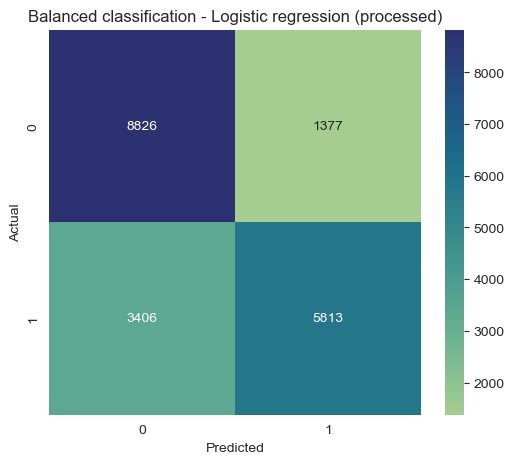

Confusion Matrix:
 [[8826 1377]
 [3406 5813]]


In [11]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, cmap='crest', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Balanced classification - Logistic regression (processed)')

plt.savefig('./figs/bal_conf_mat_log_2.png')
plt.show()

# Print confusion matrix and classification report for detailed metrics
print("Confusion Matrix:\n", cm)
